In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

In [4]:
class LSTM( nn.Module ):
    def __init__( self, input_size=1, hidden_n=100, output_size=1 ):
        super( LSTM, self ).__init__()

        self.hidden_layer_size = hidden_n
        self.lstm = nn.LSTM( input_size, hidden_n )
        self.fcn = nn.Linear( hidden_n, output_size )

        #  Hidden cell contains previous hidden state, previous cell state,
        #  randomized to start

        self.hidden_cell =\
          ( torch.zeros( 1, 1, self.hidden_layer_size ),
            torch.zeros( 1, 1, self.hidden_layer_size ) )

    #  End method __init__

    def forward( self, input_seq ):

        #  input_seq is a 12-value tensor, the 12 months of passengers to
        #  train on, normalized on the range -1..1, as a single row

        #  Input to an LSTM is of shape (sequence_length,batch,input_size),
        #  so below view creates a column of 12 "samples", each sample is
        #  a single value, a batch size of 1, and a length of 1 (one 12-value
        #  sample sequence)

        input_seq = input_seq.view( len( input_seq ), 1, 1 )

        #  Ask the LSTM for the output and the (hidden,cell) state based
        #  on the 12-value input and the current (hidden,cell) state, this
        #  will recurse the LSTM 12 times

        lstm_out,self.hidden_cell = self.lstm( input_seq, self.hidden_cell )
        lstm_out = lstm_out.view( len( input_seq ), -1 )

        #  Run the final output through the LSTM's FCN to get class
        #  probabilities

        predictions = self.fcn( lstm_out )

        #  Highest probability is the class we estimate

        return predictions[ -1 ]

    #  End method forward
#  End class LSTM

In [5]:
def create_IO_seq( input, tw ):

    #  Create a set of time series to process during training, input is the
    #  entire data stream to divide, tw is time window size in samples
    #
    #  IO_seq is a (train_seq,label) tuple list, train_seq is a 12-month
    #  set of passengers, label is a single passenger count following the
    #  12-month sequence

    IO_seq = [ ]
    n = len( input )

    for i in range( n - tw ):

        #  Grab tw elements as training sequence, next element that follows
        #  is the label (i.e., the number of passengers following the given
        #  12-month period)

        train_seq = input[ i: i + tw ]

        #  To be pendantic, pull single tensor value as float, then make
        #  a single-element float list and convert it back to a tensor;
        #  can be done in a single step as:
        #
        #  train_label = input[ i + tw: i + tw + 1 ]
        #
        #  but I found that hard to understand
        #
        #  val is a single float, the number of passengers following the
        #  12-month training sequence we just extracted
        #
        #  train_label is [ val ] (a single-element float list) as a tensor

        val = input[ i + tw ].item()
        train_label = torch.FloatTensor( [ val ] )

        IO_seq.append( (train_seq,train_label) )

    return IO_seq

#  End function create_IO_seq

epoch   1; loss: 0.04671052
epoch  26; loss: 0.01297184
epoch  51; loss: 0.00261692
epoch  76; loss: 0.00001504
epoch 101; loss: 0.00016228
epoch 126; loss: 0.02915600
epoch: 149; loss: 0.0000919544


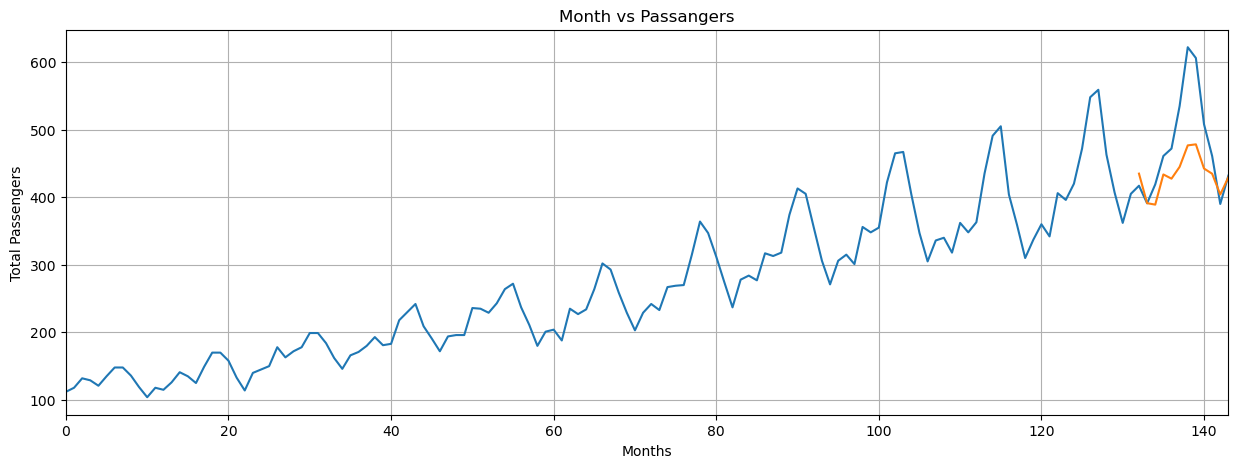

In [6]:
#  Mainline

flight_data = sns.load_dataset( 'flights' )

#  First 132 months for train, last 12 months for test, split into
#  12-month training sequences and 1-value labels:
#
#  1 2 3 4 5 6 7 8 9 10 11 12     13
#  - 12-months of training        - next value is label
#    so train on 12-month sequence..then see how many passengers next month

all_data = flight_data[ 'passengers' ].values.astype( float )
test_data_size = 12

train_data = all_data[ :-test_data_size ]
test_data = all_data[ -test_data_size: ]

#  Transform/normalize data to range -1..1

scaler = MinMaxScaler( feature_range=(-1,1) )

#  First reshape data into a single column, then transform to range -1..1

train_data_norm =\
  scaler.fit_transform( train_data.reshape( len( train_data ), 1 ) )

#  Convert back to PyTorch tensor that's a single row

train_data_norm =\
  torch.FloatTensor( train_data_norm ).view( len( train_data_norm ) )

train_window = 12
train_IO_seq = create_IO_seq( train_data_norm, train_window )

#  Create LSTM

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001 )

#  Train LSTM

model.train()

epochs = 150
for i in range( 0, epochs ):
    for seq,label in train_IO_seq:
        optimizer.zero_grad()

        #  Re-initialize hidden state and cell state to random prior to
        #  walking over the samples in the training sequence

        model.hidden_cell =\
          ( torch.zeros( 1, 1, model.hidden_layer_size ),
            torch.zeros( 1, 1, model.hidden_layer_size ) )
        
        y_pred = model( seq )

        single_loss = loss_function( y_pred, label )
        single_loss.backward()
        optimizer.step()

    if i % 25 == 1:
        print( f'epoch {i:3}; loss: {single_loss.item():10.8f}' )

print( f'epoch: {i:3}; loss: {single_loss.item():10.10f}' )

#  Predict final twelve months

model.eval()
fut_pred = 12

#  Grab last twelve months of data, this will be the sequence used to
#  predict the first test value (remember, 132 training and 12 test
#  values were stripped at the beginning of the mainline)

test_outputs = [ ]
test_inputs = train_data_norm[ -train_window: ].tolist()

#  Run through all twelve test values

for i in range( 0, fut_pred ):
    
    #  Convert list of last 12 (normalized) passengers to a tensor

    seq = torch.FloatTensor( test_inputs[ -train_window: ] )

    #  with torch.no_grad() runs the LSTM without calculating gradients, we
    #  can only do this b/c we know we don't need gradients, backwards()
    #  is not called at the end of this training run, b/c we are passing
    #  one single 12-value sequence and only care about the final output

    with torch.no_grad():
        model.hidden =\
          ( torch.zeros( 1, 1, model.hidden_layer_size ),
            torch.zeros( 1, 1, model.hidden_layer_size ) )

        #  Append output of LSTM to test_inputs, so when we loop again and
        #  grab the last 12 values for input, it includes the output(s)
        #  the LSTM is generating. Also, make sure to save the outputs for
        #  later accuracy calculations

        test_inputs.append( model( seq ).item() )
        test_outputs.append( test_inputs[ -1 ] )

#  The LSTM output is normalized on range -1..1, so we need to invert this
#  to get actual passenger numbers, need these to do a proper comparison to
#  known passenger numbers for accuracy calculation

actual_pred =\
  scaler.inverse_transform( np.array( test_outputs ).reshape( -1, 1 ) )

#  Plot the known values in blue

fig_size = plt.rcParams[ 'figure.figsize' ]
fig_size[ 0 ] = 15
fig_size[ 1 ] = 5
plt.rcParams[ 'figure.figsize' ] = fig_size
plt.title( 'Month vs Passangers' )
plt.ylabel( 'Total Passengers' )
plt.xlabel( 'Months' )
plt.grid( True )
plt.autoscale( axis='x', tight=True )
plt.plot( flight_data[ 'passengers' ] )

#  Add in the predicted values in orange

x = np.arange( 132, 144, 1 )
plt.plot( x, actual_pred )
plt.show()